# Computer Vision Homework 3: Big vs Small Models

## Brief

Due date: Nov 13, 2023

Required files: `homework-3.ipynb`, `report.pdf`

To download the jupyter notebook from colab, you can refer to the colab tutorial we gave.


## Codes for Problem 1 and Problem 2

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

### Check GPU Environment

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

Using cuda device


In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-954a9ccf-31a4-f6c4-b602-9f32b041c483)


### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

Files already downloaded and verified
Files already downloaded and verified


### Load Models

In [ ]:
# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.

#### ResNet18

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', weights=None)
model.fc = nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


#### ResNet50

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights=None)
model.fc = nn.Linear(in_features=2048, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10 # hw training for 100 epochs

train_losses = []
test_losses = []
train_acces = []
test_acces = []

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acces.append(train_acc)
    test_acces.append(test_acc)

    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.2f}")

print("Done!")

100%|██████████| 40/40 [00:02<00:00, 15.91it/s]


Epoch  1: Loss = 2.5435 Acc = 0.10 Test_Loss = 2.5097 Test_Acc = 0.10


100%|██████████| 40/40 [00:02<00:00, 15.57it/s]


Epoch  2: Loss = 2.5431 Acc = 0.10 Test_Loss = 2.5123 Test_Acc = 0.10


100%|██████████| 40/40 [00:02<00:00, 18.14it/s]


Epoch  3: Loss = 2.5456 Acc = 0.10 Test_Loss = 2.5067 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.26it/s]


Epoch  4: Loss = 2.5431 Acc = 0.10 Test_Loss = 2.5048 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.01it/s]


Epoch  5: Loss = 2.5430 Acc = 0.10 Test_Loss = 2.5094 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 22.18it/s]


Epoch  6: Loss = 2.5475 Acc = 0.10 Test_Loss = 2.5071 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.41it/s]


Epoch  7: Loss = 2.5414 Acc = 0.10 Test_Loss = 2.5067 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Epoch  8: Loss = 2.5474 Acc = 0.10 Test_Loss = 2.5115 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.62it/s]


Epoch  9: Loss = 2.5441 Acc = 0.10 Test_Loss = 2.5094 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.37it/s]

Epoch 10: Loss = 2.5426 Acc = 0.10 Test_Loss = 2.5115 Test_Acc = 0.10
Done!


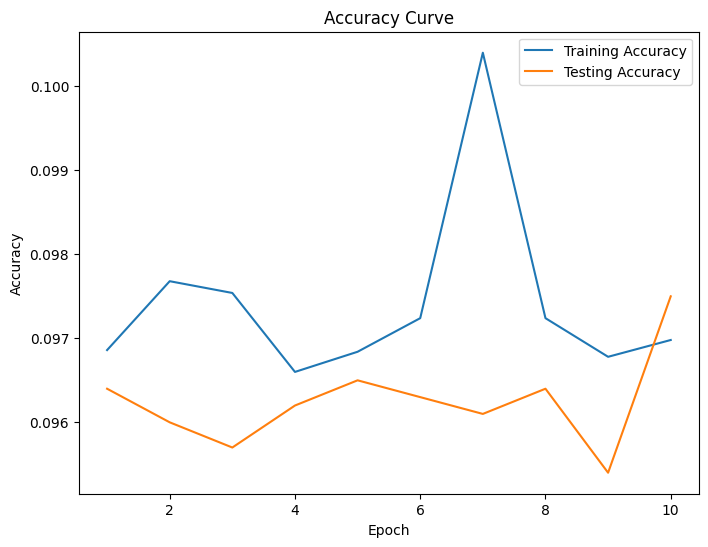

In [ ]:
# Figure 1: Training and Testing Accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_acces, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_acces, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

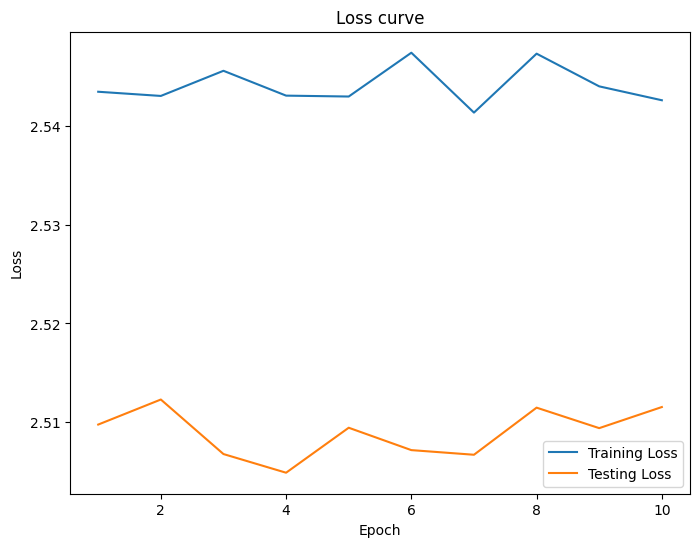

In [ ]:
# Figure 2: Training and Testing Losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.show()

## Codes for Problem 3

In [ ]:
# TODO: Try to achieve the best performance given all training data using whatever model and training strategy.
# (New) (You cannot use the model that was pretrained on CIFAR10)

### Import Packages

In [ ]:
import glob
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import DataLoader, Dataset, RandomSampler
from torchvision import transforms, models, datasets
from tqdm import tqdm

%matplotlib inline

### Set the Seed to Reproduce the Result

In [ ]:
def set_all_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
set_all_seed(123)

### Create Dataset and Dataloader

In [ ]:
batch_size = 256

mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
    transforms.ToTensor(),
    transforms.ColorJitter(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=train_transform)
valid_dataset = datasets.CIFAR10(root='data', train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

sixteenth_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//16)
half_train_sampler = RandomSampler(train_dataset, num_samples=len(train_dataset)//2)

sixteenth_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sixteenth_train_sampler)
half_train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=half_train_sampler)

Files already downloaded and verified
Files already downloaded and verified


### Load Models

In [ ]:
model_type = 'densenet121'

# HINT: Remember to change the model to 'resnet50' and the weights to weights="IMAGENET1K_V1" when needed.
model = torch.hub.load('pytorch/vision:v0.10.0', model_type, weights="IMAGENET1K_V1")

# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.

#### DenseNet121

In [ ]:
# Background: The original resnet18 is designed for ImageNet dataset to predict 1000 classes.
# TODO: Change the output of the model to 10 class.
# num_features = model.fc.in_features
num_features = model.classifier.in_features
model.fc = nn.Linear(in_features=num_features, out_features=10, bias=True)
model = model.to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


### Training and Testing Models

In [ ]:
# TODO: Fill in the code cell according to the pytorch tutorial we gave.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.train()

    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
def test(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    epoch_loss = 0
    correct = 0

    model.eval()

    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)

            pred = model(X)

            epoch_loss += loss_fn(pred, y).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(y.view_as(pred)).sum().item()

    avg_epoch_loss = epoch_loss / num_batches
    avg_acc = correct / size

    return avg_epoch_loss, avg_acc

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 10 # hw training for 100 epochs

train_losses = []
test_losses = []
train_acces = []
test_acces = []

for epoch in range(epochs):
    train_loss, train_acc = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test(valid_dataloader, model, loss_fn)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_acces.append(train_acc)
    test_acces.append(test_acc)

    print(f"Epoch {epoch + 1:2d}: Loss = {train_loss:.4f} Acc = {train_acc:.2f} Test_Loss = {test_loss:.4f} Test_Acc = {test_acc:.3f}")

print("Done!")

100%|██████████| 40/40 [00:02<00:00, 15.91it/s]


Epoch  1: Loss = 2.5435 Acc = 0.10 Test_Loss = 2.5097 Test_Acc = 0.10


100%|██████████| 40/40 [00:02<00:00, 15.57it/s]


Epoch  2: Loss = 2.5431 Acc = 0.10 Test_Loss = 2.5123 Test_Acc = 0.10


100%|██████████| 40/40 [00:02<00:00, 18.14it/s]


Epoch  3: Loss = 2.5456 Acc = 0.10 Test_Loss = 2.5067 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.26it/s]


Epoch  4: Loss = 2.5431 Acc = 0.10 Test_Loss = 2.5048 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.01it/s]


Epoch  5: Loss = 2.5430 Acc = 0.10 Test_Loss = 2.5094 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 22.18it/s]


Epoch  6: Loss = 2.5475 Acc = 0.10 Test_Loss = 2.5071 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.41it/s]


Epoch  7: Loss = 2.5414 Acc = 0.10 Test_Loss = 2.5067 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 20.75it/s]


Epoch  8: Loss = 2.5474 Acc = 0.10 Test_Loss = 2.5115 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.62it/s]


Epoch  9: Loss = 2.5441 Acc = 0.10 Test_Loss = 2.5094 Test_Acc = 0.10


100%|██████████| 40/40 [00:01<00:00, 21.37it/s]

Epoch 10: Loss = 2.5426 Acc = 0.10 Test_Loss = 2.5115 Test_Acc = 0.10
Done!


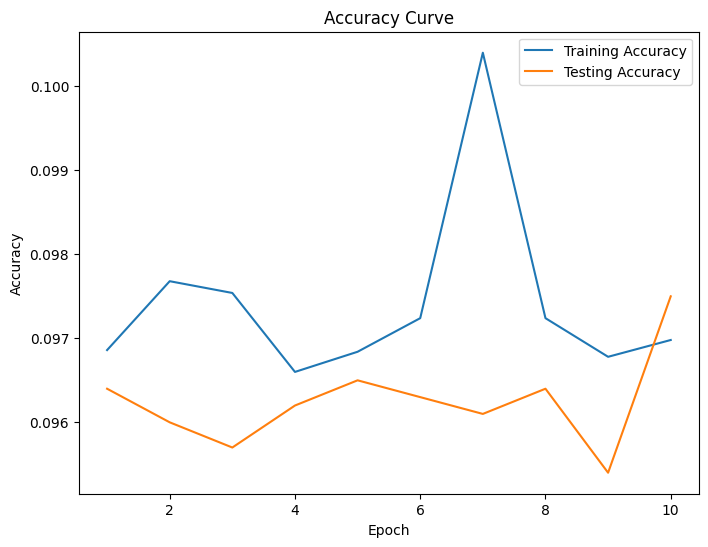

In [ ]:
# Figure 1: Training and Testing Accuracies
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_acces, label="Training Accuracy")
plt.plot(range(1, epochs + 1), test_acces, label="Testing Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")
plt.show()

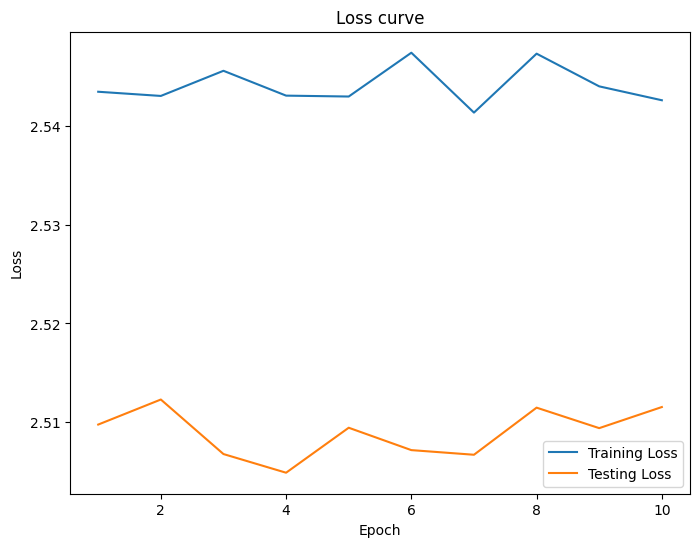

In [ ]:
# Figure 2: Training and Testing Losses
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, epochs + 1), test_losses, label="Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss curve")
plt.show()

1. (30%) Finish the rest of the codes for Problem 1 and Problem 2 according to the hint. (2 code cells in total.)
2. Train small model (resnet18) and big model (resnet50) from scratch on `sixteenth_train_dataloader`, `half_train_dataloader`, and `train_dataloader` respectively.
3. (30%) Achieve the best performance given all training data using whatever model and training strategy.  
  (You cannot use the model that was pretrained on CIFAR10)



## Discussion

Write down your insights in the report. The file name should be report.pdf.
For the following discussion, please present the results graphically as shown in Fig. 1 and discuss them.

- (30%) The relationship between the accuracy, model size, and the training dataset size.  
    (Total 6 models. Small model trains on the sixteenth, half, and all data. Big model trains on the sixteenth, half, and all data. If the result is different from Fig.1, please explain the possible reasons.)
- (10%) What if we train the ResNet with ImageNet initialized weights (`weights="IMAGENET1K_V1"`).
Please explain why the relationship changed this way?

Hint: You can try different hyperparameters combinations when training the models.

## Credits

1. [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)
2. [DenseNet121](https://github.com/onnx/models/blob/main/vision/classification/densenet-121/README.md)